## Style Transfer Using GAN

### Variables, Hyperparamaters and libraries import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Import all the required libraries
# %pip install pandas numpy tensorflow matplotlib imageio scikit-image
# %pip install git+https://github.com/tensorflow/docs
import os
from os import listdir
import time
import glob
import imageio
import numpy as np
import tensorflow as tf
from numpy import asarray
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from skimage.io import imread
import matplotlib.pyplot as plt
from skimage.transform import resize
from tensorflow.keras.utils import plot_model
#import tensorflow_docs.vis.embed as embed

In [ ]:
OUTPUT_FOLDER = './Output/'
TIMESTAMP = str(time.strftime('%Y%m%d%H%M%S'))
TEMP_FOLDER = OUTPUT_FOLDER + TIMESTAMP + '/'

if os.path.exists(OUTPUT_FOLDER):
    os.mkdir(TEMP_FOLDER)
else:
    os.mkdir(OUTPUT_FOLDER)
    os.mkdir(TEMP_FOLDER)

BUFFER_SIZE = 35
BATCH_SIZE = 5

IMG_HEIGHT = 128
IMG_WIDTH = 128

### Data Initialization and Loading

In [ ]:
# load and resize images
def load_images(path, size=(IMG_HEIGHT,IMG_WIDTH)):
    data_list = list()

    for filename in listdir(path):
        pixels = load_img(path + filename, target_size=size)
        # convert to numpy array
        pixels = img_to_array(pixels)
        # store the data
        data_list.append(pixels)
    return asarray(data_list)

In [ ]:
tr1_data = load_images('/content/drive/MyDrive/Brain_MRI_Scans/Tr1/TrainT1/')
tr2_data = load_images('/content/drive/MyDrive/Brain_MRI_Scans/Tr2/TrainT2/')

#convert to grayscale
tr1_data = tf.image.rgb_to_grayscale(tr1_data)
tr2_data = tf.image.rgb_to_grayscale(tr2_data)

In [ ]:
np.min(tr1_data[0]), np.max(tr1_data[0])

(np.float32(0.0), np.float32(252.9747))

##Data Augmentation

In [ ]:

#Simulates thermal/electronic noise in scanners
def add_gaussian_noise(image, mean=0.0, stddev=15.0):
    noise = tf.random.normal(shape=tf.shape(image), mean=mean, stddev=stddev, dtype=tf.float32)
    noisy_image = tf.clip_by_value(image + noise, 0.0, 255.0)
    return noisy_image

# Mimics scanner calibration issues
def intensity_shift(image, shift_range=30):
    shift = tf.random.uniform([], -shift_range, shift_range, dtype=tf.float32)
    shifted_image = image + shift
    return tf.clip_by_value(shifted_image, 0.0, 255.0)


#Simulates non-uniform magnetic field causing smooth illumination bias
def intensity_gradient(image):
    height, width, _ = image.shape
    gradient = tf.linspace(0.8, 1.2, width)
    gradient = tf.reshape(gradient, (1, width, 1))
    biased_image = image * gradient
    return tf.clip_by_value(biased_image, 0.0, 255.0)

#MRI scans from different scanners may have varying contrast levels
def random_contrast(image, lower=0.7, upper=1.3):
    # Contrast variation in the range [0, 255]
    contrast_factor = tf.random.uniform([], lower, upper)
    contrast_image = image * contrast_factor
    return tf.clip_by_value(contrast_image, 0.0, 255.0)


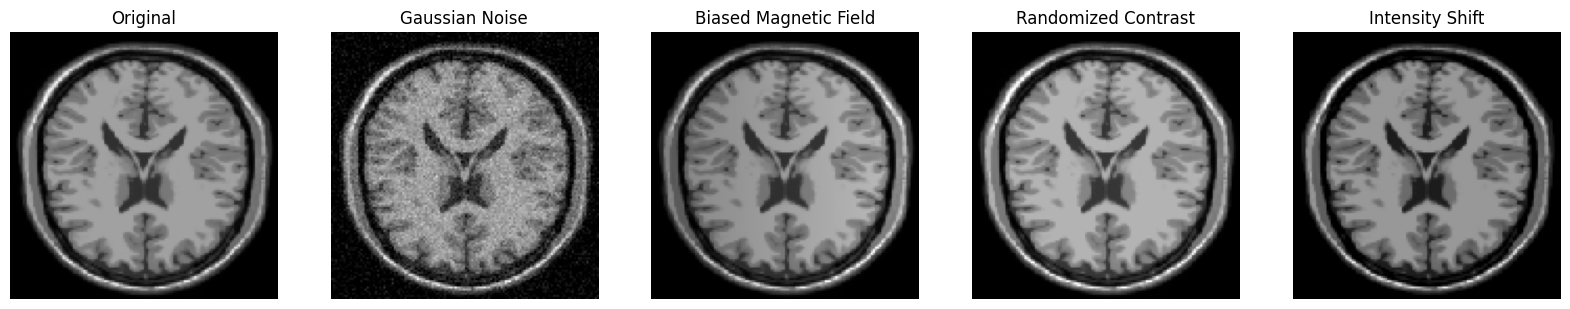

In [ ]:
# Visualize all
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

axs[0].imshow(tr1_data[0], cmap="grey")  # Original
axs[0].set_title('Original')
axs[1].imshow(add_gaussian_noise(tr1_data[0]), cmap="grey")
axs[1].set_title('Gaussian Noise')
axs[2].imshow(intensity_gradient(tr1_data[0]), cmap="grey")
axs[2].set_title('Biased Magnetic Field')
axs[3].imshow(random_contrast(tr1_data[0]), cmap="grey")
axs[3].set_title('Randomized Contrast')
axs[4].imshow(intensity_shift(tr1_data[0]), cmap="grey")
axs[4].set_title('Intensity Shift')

for ax in axs:
    ax.axis('off')

plt.show()

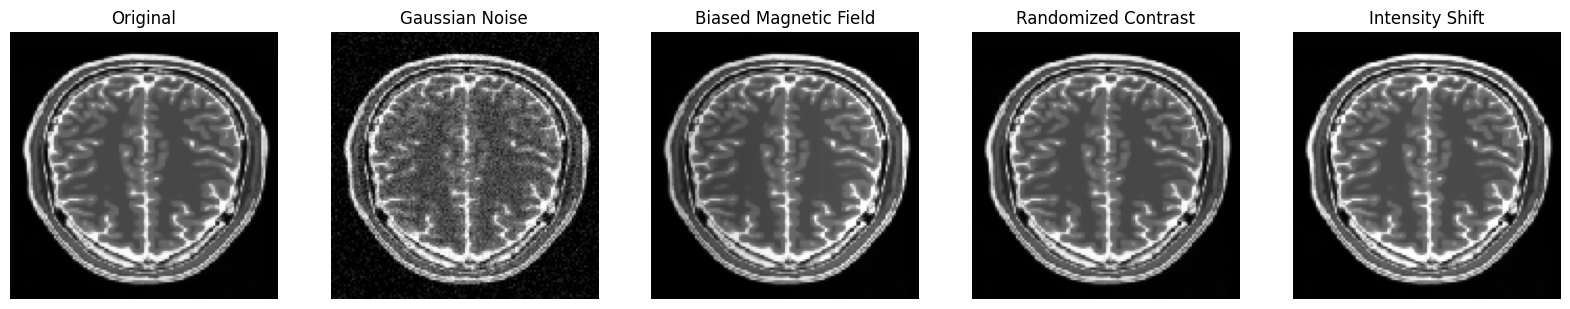

In [ ]:
# Visualize all
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

axs[0].imshow(tr2_data[0], cmap="grey")  # Original
axs[0].set_title('Original')
axs[1].imshow(add_gaussian_noise(tr2_data[0]), cmap="grey")
axs[1].set_title('Gaussian Noise')
axs[2].imshow(intensity_gradient(tr2_data[0]), cmap="grey")
axs[2].set_title('Biased Magnetic Field')
axs[3].imshow(random_contrast(tr2_data[0]), cmap="grey")
axs[3].set_title('Randomized Contrast')
axs[4].imshow(intensity_shift(tr2_data[0]), cmap="grey")
axs[4].set_title('Intensity Shift')

for ax in axs:
    ax.axis('off')

plt.show()

In [ ]:
import random
from tensorflow.keras.utils import save_img

In [ ]:
# # === Apply a random combination of 1 to 3 augmentations ===

# AUGMENTATIONS = [add_gaussian_noise, intensity_gradient, random_contrast, intensity_shift]

# def apply_random_augmentations(image):
#     num_augments = random.randint(1, 3)
#     aug_funcs = random.sample(AUGMENTATIONS, num_augments)
#     aug_image = tf.identity(image)
#     for func in aug_funcs:
#         aug_image = func(aug_image)
#     return aug_image

# # === Main Processing Function ===

# def process_and_save_augmented_images(input_folder, output_folder, target_size=(128, 128)):
#     os.makedirs(output_folder, exist_ok=True)
#     filenames = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png'))]

#     for filename in filenames:
#         image_path = os.path.join(input_folder, filename)
#         image = load_img(image_path, target_size=target_size)
#         image = img_to_array(image)  # This will be float32 in 0–255 range

#         for i in range(2):  # Generate 2 augmented versions
#             aug_image = apply_random_augmentations(image)
#             aug_filename = f"{os.path.splitext(filename)[0]}_aug{i+1}.png"
#             save_img(os.path.join(output_folder, aug_filename), aug_image)

#     print("All augmentations saved!")


In [ ]:
# # For T1 style images
# input_dir = r"G:\My Drive\Brain_MRI_Scans\Tr1\TrainT1"
# output_dir = r"G:\My Drive\Brain_MRI_Scans\Augmented+Real_T1"

# process_and_save_augmented_images(input_dir, output_dir)

In [ ]:
# #For T2 style images
# input_dir = r"G:\My Drive\Brain_MRI_Scans\Tr2\TrainT2"
# output_dir = r"G:\My Drive\Brain_MRI_Scans\Augmented+Real_T2"

# process_and_save_augmented_images(input_dir, output_dir)

In [ ]:
tr1_data = load_images('/content/drive/MyDrive/Brain_MRI_Scans/Augmented+Real_T1/')
tr2_data = load_images('/content/drive/MyDrive/Brain_MRI_Scans/Augmented+Real_T2/')

#convert to grayscale
tr1_data = tf.image.rgb_to_grayscale(tr1_data)
tr2_data = tf.image.rgb_to_grayscale(tr2_data)

print(tr1_data.shape)
print(tr2_data.shape)
tr1= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr1_data))
tr2= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(tr2_data))

tr1

(105, 128, 128, 1)
(111, 128, 128, 1)


<_TensorSliceDataset element_spec=TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None)>

In [ ]:
tr2

<_TensorSliceDataset element_spec=TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None)>

### Image Preprocessing

#### Image to Pixel conversion

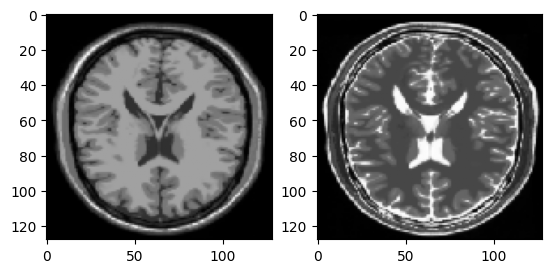

In [ ]:
# Convert images to pixels and append it to a dataframe
fig, axs = plt.subplots(1,2)
axs[0].imshow(tr1_data[0], cmap='grey')
axs[1].imshow(tr2_data[0], cmap='grey')
plt.show();

#### Image Resizing & pixel Normalization

In [ ]:
def normalize(image):
    image =  tf.cast(image, tf.float32)
    image= (image / 127.5) - 1
    return image

def preprocess_image_train(image):
    image = tf.image.random_flip_left_right(image)
    image = normalize(image)
    return image

AUTOTUNE = tf.data.experimental.AUTOTUNE
tr1 = tr1.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
tr2 = tr2.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


#### Image Reshaping, Shuffling and Batch Processing

In [ ]:
sample_tr1 = next(iter(tr1))
sample_tr2 = next(iter(tr2))

### Loss Functions & Optimizer

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real, generated):
    real_loss = loss_obj(tf.ones_like(real), real)
    generated_loss = loss_obj(tf.zeros_like(generated), generated)
    total_disc_loss = real_loss + generated_loss
    return total_disc_loss * 0.5

def generator_loss(generated):
    return loss_obj(tf.ones_like(generated), generated)

def cycle_loss(real_image, cycled_image):
    loss = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return 10.0 * loss

def identity_loss(real_image, same_image):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return 0.5 * loss

generator_g_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(1e-4, beta_1=0.5)

### Model Building

#### Instance Normalization

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
    # Initialization of Objects
    def __init__(self, epsilon=1e-5):
        # calling parent's init
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.scale = self.add_weight(
            name='scale',
            shape=input_shape[-1:],
            initializer=tf.random_normal_initializer(1., 0.02),
            trainable=True)
        self.offset = self.add_weight(
            name='offset',
            shape=input_shape[-1:],
            initializer='zeros',
            trainable=True)

    def call(self, x):
        # Compute Mean and Variance, Axes=[1,2] ensures Instance Normalization
        mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
        inv = tf.math.rsqrt(variance + self.epsilon)
        normalized = (x - mean) * inv
        return self.scale * normalized + self.offset

#### Downsampling and Upsampling

In [ ]:
def downsample(filters, size, apply_norm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Conv2d layer
    result.add(tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    # Add Normalization layer
    if apply_norm:
        result.add(InstanceNormalization())
    # Add Leaky Relu Activation
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = tf.keras.Sequential()
    # Add Transposed Conv2d layer
    result.add(tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                               kernel_initializer=initializer, use_bias=False))
    # Add Normalization Layer
    result.add(InstanceNormalization())
    # Conditionally add Dropout layer
    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))
    # Add Relu Activation Layer
    result.add(tf.keras.layers.ReLU())
    return result

#### Generator

In [ ]:
# Unet Generator is a combination of Convolution + Transposed Convolution Layers
def unet_generator():
    down_stack = [
        downsample(64, 4, False),
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4),
        downsample(512, 4)
        # downsample(512, 4)

    ]
    up_stack = [
        upsample(512, 4, True),
        upsample(512, 4, True),
        # upsample(512, 4, True),
        upsample(512, 4),
        upsample(256, 4),
        upsample(128, 4),
        upsample(64, 4)
    ]
    initializer = tf.random_normal_initializer(0., 0.02)
    last = tf.keras.layers.Conv2DTranspose(1, 4, strides=2, padding='same', kernel_initializer=initializer,
                                           activation='tanh') # (bs, 32, 32, 1)
    concat = tf.keras.layers.Concatenate()
    inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1])
    x = inputs
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = concat([x, skip])
    x = last(x)
    return tf.keras.Model(inputs=inputs, outputs=x)

In [ ]:
generator_g = unet_generator()
generator_f = unet_generator()

generator_g.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64, 64,    │      1,024 │ input_layer[0][0] │
│ (Sequential)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 32, 32,    │    131,328 │ sequential[0][0]  │
│ (Sequential)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 16, 16,    │    524,800 │ sequential_1[0][… │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 8, 8, 512) │  2,098,176 │ sequential_2[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_4        │ (None, 4, 4, 512) │  4,195,328 │ sequential_3[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_5        │ (None, 2, 2, 512) │  4,195,328 │ sequential_4[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 1, 1, 512) │  4,195,328 │ sequential_5[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 2, 2, 512) │  4,195,328 │ sequential_6[0][… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64, 64,    │          0 │ sequential_7[0][… │
│ (Concatenate)       │ 128)              │            │ sequential_5[0][… │
│                     │                   │            │ sequential_8[0][… │
│                     │                   │            │ sequential_4[0][… │
│                     │                   │            │ sequential_9[0][… │
│                     │                   │            │ sequential_3[0][… │
│                     │                   │            │ sequential_10[0]… │
│                     │                   │            │ sequential_2[0][… │
│                     │                   │            │ sequential_11[0]… │
│                     │                   │            │ sequential_1[0][… │
│                     │                   │            │ sequential_12[0]… │
│                     │                   │            │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 4, 4, 512) │  8,389,632 │ concatenate[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 8, 8, 512) │  8,389,632 │ concatenate[1][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 16, 16,    │  4,194,816 │ concatenate[2][0] │
│ (Sequential)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 41,823,873 (159.55 MB)

 Trainable params: 41,823,873 (159.55 MB)

 Non-trainable params: 0 (0.00 B)

#### Discriminator

In [ ]:
# Discriminators only contain Convolutional Layers and no Transposed Convolution is not used
def discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    # add input layer of size (32, 32, 1)
    inp = tf.keras.layers.Input(shape=[IMG_HEIGHT, IMG_WIDTH, 1], name='input_image')
    x = inp

    # add downsampling step here
    down1 = downsample(64, 4, False)(x) # (bs, 16, 16, 64)
    down2 = downsample(128, 4)(down1) # (bs, 8, 8, 128)
    down3 = downsample(256, 4)(down2) # (bs, 8, 8, 128)
    # add a padding layer here
    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3) # (bs, 10, 10, 128)

    # implement a concrete downsampling layer here
    conv = tf.keras.layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer,
                                  use_bias=False)(zero_pad1) # (bs, 7, 7, 256)
    norm1 = InstanceNormalization()(conv)
    leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

    # apply zero padding layer
    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu) # (bs, 9, 9, 256)

    # add a last pure 2D Convolution layer
    last = tf.keras.layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 6, 6, 1)
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
discriminator_x = discriminator()
discriminator_y = discriminator()

discriminator_x.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_26 (Sequential)      │ (None, 64, 64, 64)     │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_27 (Sequential)      │ (None, 32, 32, 128)    │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_28 (Sequential)      │ (None, 16, 16, 256)    │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 15, 15, 512)    │     2,097,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_26       │ (None, 15, 15, 512)    │         1,024 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_17 (LeakyReLU)      │ (None, 15, 15, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d_1                │ (None, 17, 17, 512)    │             0 │
│ (ZeroPadding2D)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 14, 14, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,763,521 (10.54 MB)

 Trainable params: 2,763,521 (10.54 MB)

 Non-trainable params: 0 (0.00 B)

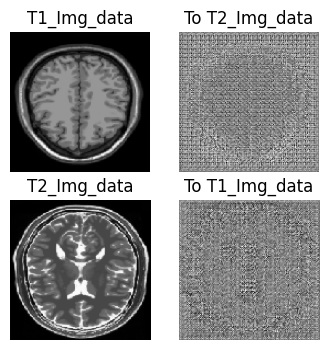

In [ ]:
to_t2_img_data = generator_g(sample_tr1)
to_t1_img_data = generator_f(sample_tr2)
plt.figure(figsize=(4, 4))

imgs = [sample_tr1, to_t2_img_data, sample_tr2, to_t1_img_data]
title = ['T1_Img_data', 'To T2_Img_data', 'T2_Img_data', 'To T1_Img_data']

for i in range(len(imgs)):
    plt.subplot(2, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0], cmap='gray')
    plt.axis('off')
plt.show()

### Model Training

#### Checkpoint Initialization

In [ ]:
checkpoint_path = "/content/Output/20250504151440/" +"Trained_Model"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=3)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [ ]:

def generate_images(model1, test_input1, model2, test_input2, epoch):
    prediction1 = model1(test_input1)
    prediction2 = model2(test_input2)
    plt.figure(figsize=(8, 4))
    display_list = [test_input1[0], prediction1[0], test_input2[0], prediction2[0]]
    title = ['Input Image', 'Predicted Image', 'Input Image', 'Predicted Image']
    for i in range(4):
        plt.subplot(1, 4, i+1)
        plt.title(title[i])
        plt.imshow(display_list[i].numpy()[:, :, 0], cmap='gray')
        plt.axis('off')

    plt.savefig(TEMP_FOLDER +'image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [ ]:
@tf.function
def train_step(real_x, real_y):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X
        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)

        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = cycle_loss(real_x, cycled_x) + cycle_loss(real_y, cycled_y)

        # Total generator loss = BCE loss + cycle loss + identity loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        # Discriminator's loss
        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))
    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))
    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))

In [ ]:
EPOCHS = 10

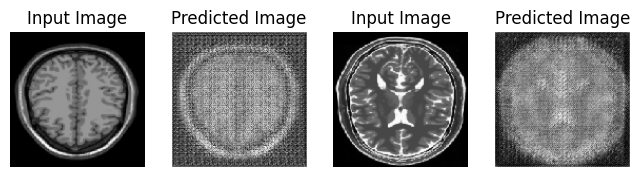

Saving checkpoint for epoch 1 at /content/Output/20250504151440/Trained_Model/ckpt-1


In [ ]:
for epoch in range(1, EPOCHS+1):
    for image_x, image_y in tf.data.Dataset.zip((tr1, tr2)):
        train_step(image_x, image_y)
    generate_images(generator_g, sample_tr1, generator_f, sample_tr2, epoch)
    ckpt_save_path = ckpt_manager.save()
    print('Saving checkpoint for epoch', epoch, 'at', ckpt_save_path)

In [ ]:
anim_file = TEMP_FOLDER + 'cyclegan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob( TEMP_FOLDER + 'image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

<ipython-input-141-a5fa925ba11c>:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)
<ipython-input-141-a5fa925ba11c>:9: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)



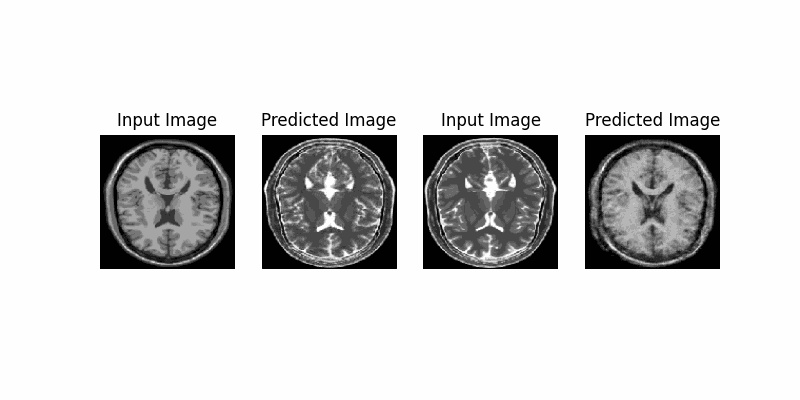

In [ ]:
embed.embed_file(anim_file)

In [ ]:
def test_model(model, test_input):
    prediction = model(test_input)
    plt.figure(figsize=(5, 5))
    display_list = [test_input[0], prediction[0]]
    title = ['Input Image', 'Predicted Image', 'Expected Image']
    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i].numpy()[:, :, 0] * 0.5 + 0.5, cmap='gray')
        plt.axis('off')
    plt.show()

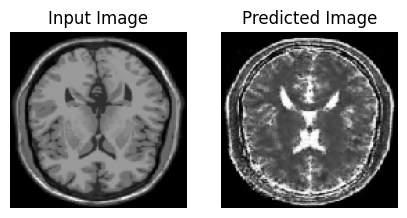

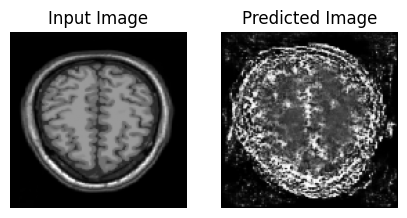

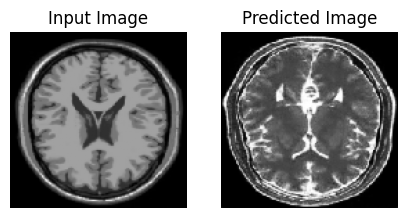

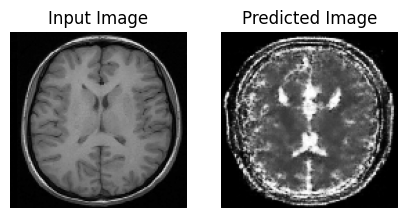

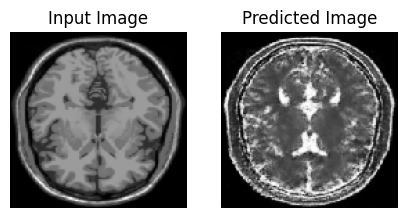

In [ ]:
# Run the trained model on the test dataset
for inp in tr1.take(5):
    test_model(generator_g, inp)

In [ ]:

test_image = load_img("/content/test1.png", target_size=(IMG_HEIGHT,IMG_WIDTH))
        # convert to numpy array
test_image = img_to_array(test_image)
        # store the data
print(test_image.shape)
test_image = asarray(test_image)
 #convert to grayscale
test_image = tf.image.rgb_to_grayscale(test_image)
test_image = tf.expand_dims(test_image, axis=0)
print(test_image.shape)

test= tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(test_image))

test

(128, 128, 3)
(1, 128, 128, 1)


<_TensorSliceDataset element_spec=TensorSpec(shape=(128, 128, 1), dtype=tf.float32, name=None)>

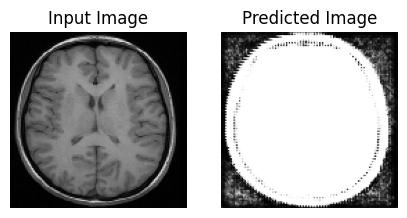

In [ ]:
for p in test.take(1): # Takes 1 batch
    test_model(generator_g, test_image)         # Predict 1 batch


In [ ]:
!zip -r /content/output.zip /content/Output/20250504151440


  adding: content/Output/20250504151440/ (stored 0%)
  adding: content/Output/20250504151440/image_at_epoch_0064.png (deflated 7%)
  adding: content/Output/20250504151440/Trained_Model/ (stored 0%)
  adding: content/Output/20250504151440/Trained_Model/ckpt-109.index (deflated 78%)
  adding: content/Output/20250504151440/Trained_Model/ckpt-111.index (deflated 78%)
  adding: content/Output/20250504151440/Trained_Model/ckpt-110.data-00000-of-00001 (deflated 26%)
  adding: content/Output/20250504151440/Trained_Model/ckpt-111.data-00000-of-00001